In [2]:
import h5py
import librosa
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


file = h5py.File('dataset.h5', 'r')
#label_dict = {"['n']": 0, "['c']": 1, "['h']": 2, "['s']": 3,
 #             "['a']": 4, "['f']": 5, "['d']": 6, "['su']": 7}
#label_dict = {"[b'n']": 0, "[b'c']": 1, "[b'h']": 2, "[b'sa']": 3,
              #"[b'a']": 4, "[b'f']": 5, "[b'd']": 6, "[b'su']": 7}

In [3]:
#z = file['stft'][:10]
#print(z[1].shape)

In [4]:
X, y = file['mfcc'][:36406], file['label'][:36406]

mfcc_delta = librosa.feature.delta(X)
mfcc_delta2 = librosa.feature.delta(X, order = 2)

#X_test, y_test = file['mfcc'][], file['label'][]
#file['mfcc'].shape

In [5]:
X_deltas = np.concatenate((X,mfcc_delta, mfcc_delta2), axis = 1)

In [6]:
X_deltas.shape

(36406, 36, 42)

In [7]:
y.shape

(36406, 1)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_deltas, y, test_size=0.33, random_state=42)

array([4], dtype=int64)

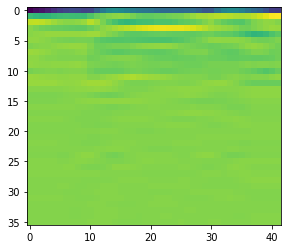

In [9]:
plt.imshow(X_train[6])
y_train[6]

In [15]:

model = Sequential()

model.add(tf.keras.layers.Reshape((36, 42, 1), input_shape=(36,42)))
model.add(Conv2D(128, (3,3),padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (2,2),padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (1,1),padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))
model.add(Activation('relu'))

#model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(8, activation='softmax'))

#model = Sequential()
#model.add(tf.keras.layers.Reshape((12, 42, 1), input_shape=(12,42)))
#model.add(Conv2D(128, 5,padding='same',
                 #input_shape=(12,42)))
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(MaxPooling2D(pool_size=(8)))
#model.add(Conv2D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(Flatten())
#model.add(Dense(8))
#model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.000005, rho=0.9, epsilon=None, decay=0.0)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 36, 42, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 42, 128)       1280      
                                                                 
 activation_3 (Activation)   (None, 36, 42, 128)       0         
                                                                 
 dropout_2 (Dropout)         (None, 36, 42, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 42, 128)       65664     
                                                                 
 activation_4 (Activation)   (None, 36, 42, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 21, 128)     

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [14]:
cnnhistory=model.fit(X_train, y_train, batch_size=512, epochs=10,validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
24/24 [==============================] - 229s 9s/step - loss: 2.0376 - accuracy: 0.1639 - val_loss: 1.9567 - val_accuracy: 0.1601
Epoch 2/10
24/24 [==============================] - 260s 11s/step - loss: 1.9608 - accuracy: 0.1603 - val_loss: 1.9448 - val_accuracy: 0.1725
Epoch 3/10
24/24 [==============================] - 221s 9s/step - loss: 1.9479 - accuracy: 0.1671 - val_loss: 1.9112 - val_accuracy: 0.2022
Epoch 4/10
24/24 [==============================] - 236s 10s/step - loss: 1.8930 - accuracy: 0.2060 - val_loss: 1.8010 - val_accuracy: 0.2615
Epoch 5/10
24/24 [==============================] - 268s 11s/step - loss: 1.8086 - accuracy: 0.2548 - val_loss: 1.7326 - val_accuracy: 0.3010
Epoch 6/10
24/24 [==============================] - 259s 11s/step - loss: 1.7469 - accuracy: 0.2898 - val_loss: 1.6675 - val_accuracy: 0.3401
Epoch 7/10
24/24 [==============================] - 265s 11s/step - loss: 1.7021 - accuracy: 0.3071 - val_loss: 1.6279 - val_accuracy: 0.3342
Epoch 8/

KeyboardInterrupt: 

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import os
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = 'C:\\Users\\Admin\\Documents\\GitHub\\VocalEmotionSensor'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
